<a href="https://colab.research.google.com/github/rachelhakes/Capstone-Project/blob/main/Pretrained_Heatmap_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# some_file.py
import sys

# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/gdrive/MyDrive/Project/LDL/code')

In [ ]:
import torch
import torch.nn as nn
# from torchvision.models import resnet152
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import cv2
# from utils.utils import Logger, AverageMeter, time_to_str, weights_init
# from utils.genLD import genLD
# from utils.report import report_precision_se_sp_yi, report_mae_mse
# import torch.utils.model_zoo as model_zoo
from model.resnet50 import *
import time
from dataset import dataset_processing

In [ ]:
class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None

        #PRETRAINED MODEL
        self.pretrained = resnet34() #### change this to what model you want to use
        #### change below to your saved model
        #### do not forget to change the corresponding model in resnet50.py
        cp_path = '/content/gdrive/MyDrive/Project/Models/model_resnet34-all5_40epoch.pth'
        self.pretrained.load_state_dict(torch.load(cp_path))
        self.layerhook.append(self.pretrained.layer4.register_forward_hook(self.forward_hook()))

        for p in self.pretrained.parameters():
            p.requires_grad = True

    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out

In [ ]:
gcmodel = GradCamModel()#.to('cuda:0')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/content/gdrive/MyDrive/Project/LDL/code/model/resnet50.py:110: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/gdrive/MyDrive/Project/LDL/code/model/resnet50.py:112: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 12
NUM_CLASSES = 4

In [ ]:
DATA_PATH = '/content/gdrive/MyDrive/Project/Classification/JPEGImages'
TRAIN_FILE = "/content/gdrive/MyDrive/Project/Detection/VOC2007/ImageSets/Main/NNEW_trainval_1.txt"
TEST_FILE = '/content/gdrive/MyDrive/Project/Detection/VOC2007/ImageSets/Main/NNEW_test_1.txt'


normalize = transforms.Normalize(mean=[0.45815152, 0.361242, 0.29348266],
                                  std=[0.2814769, 0.226306, 0.20132513])


dset_test = dataset_processing.DatasetProcessing(
        DATA_PATH, TEST_FILE, transform=transforms.Compose([
                ##### Scale does not work -- changed to Resize
                #transforms.Scale((224, 224)),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                normalize,
            ]))

test_loader = data.DataLoader(dset_test,
                             batch_size=1,
                             shuffle=False)
                             #num_workers=12,
                             #pin_memory=True)

In [ ]:
_ = gcmodel.eval()

In [ ]:
test_files = np.loadtxt(TEST_FILE, dtype='str')
test_files

array([['levle0_60.jpg', '0', '1'],
       ['levle0_483.jpg', '0', '2'],
       ['levle0_110.jpg', '0', '2'],
       ['levle0_404.jpg', '0', '1'],
       ['levle0_155.jpg', '0', '1'],
       ['levle0_329.jpg', '0', '1'],
       ['levle0_49.jpg', '0', '3'],
       ['levle0_113.jpg', '0', '1'],
       ['levle0_385.jpg', '0', '1'],
       ['levle0_267.jpg', '0', '1'],
       ['levle0_216.jpg', '0', '2'],
       ['levle0_89.jpg', '0', '1'],
       ['levle0_28.jpg', '0', '1'],
       ['levle0_190.jpg', '0', '2'],
       ['levle0_172.jpg', '0', '4'],
       ['levle0_160.jpg', '0', '3'],
       ['levle0_516.jpg', '0', '3'],
       ['levle0_45.jpg', '0', '2'],
       ['levle0_70.jpg', '0', '2'],
       ['levle0_81.jpg', '0', '2'],
       ['levle0_306.jpg', '0', '2'],
       ['levle0_198.jpg', '0', '3'],
       ['levle0_20.jpg', '0', '3'],
       ['levle0_96.jpg', '0', '1'],
       ['levle0_454.jpg', '0', '2'],
       ['levle0_162.jpg', '0', '2'],
       ['levle0_229.jpg', '0', '4'],
       ['l

In [ ]:
test_files[0]

array(['levle0_60.jpg', '0', '1'], dtype='<U14')

In [ ]:
all_test_files, y_true = [t[0] for t in test_files], [t[1] for t in test_files]
all_test_files

['levle0_60.jpg',
 'levle0_483.jpg',
 'levle0_110.jpg',
 'levle0_404.jpg',
 'levle0_155.jpg',
 'levle0_329.jpg',
 'levle0_49.jpg',
 'levle0_113.jpg',
 'levle0_385.jpg',
 'levle0_267.jpg',
 'levle0_216.jpg',
 'levle0_89.jpg',
 'levle0_28.jpg',
 'levle0_190.jpg',
 'levle0_172.jpg',
 'levle0_160.jpg',
 'levle0_516.jpg',
 'levle0_45.jpg',
 'levle0_70.jpg',
 'levle0_81.jpg',
 'levle0_306.jpg',
 'levle0_198.jpg',
 'levle0_20.jpg',
 'levle0_96.jpg',
 'levle0_454.jpg',
 'levle0_162.jpg',
 'levle0_229.jpg',
 'levle0_425.jpg',
 'levle0_36.jpg',
 'levle0_457.jpg',
 'levle0_209.jpg',
 'levle0_87.jpg',
 'levle0_17.jpg',
 'levle0_173.jpg',
 'levle0_441.jpg',
 'levle0_518.jpg',
 'levle0_422.jpg',
 'levle0_296.jpg',
 'levle0_48.jpg',
 'levle0_158.jpg',
 'levle0_367.jpg',
 'levle0_195.jpg',
 'levle0_116.jpg',
 'levle0_244.jpg',
 'levle0_351.jpg',
 'levle0_76.jpg',
 'levle0_529.jpg',
 'levle0_349.jpg',
 'levle0_530.jpg',
 'levle0_413.jpg',
 'levle0_268.jpg',
 'levle0_526.jpg',
 'levle0_462.jpg',
 'levle

In [ ]:
y_preds, y_preds_counts, y_preds_count2cls = [], [], []

/content/gdrive/MyDrive/Project/LDL/code/model/resnet50.py:249: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls = F.softmax(cls) + 1e-4
/content/gdrive/MyDrive/Project/LDL/code/model/resnet50.py:250: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cou = F.softmax(cou) + 1e-4
/content/gdrive/MyDrive/Project/LDL/code/model/resnet50.py:110: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
/content/gdrive/MyDrive/Project/LDL/code/model/resnet50.py:112: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


0
levle3_30.jpg
tensor([0])
tensor([0])
tensor([0])
1
levle0_60.jpg
tensor([0])
tensor([1])
tensor([0])
2
levle0_483.jpg
tensor([0])
tensor([1])
tensor([0])
3
levle0_110.jpg
tensor([0])
tensor([1])
tensor([0])
4
levle0_404.jpg
tensor([0])
tensor([1])
tensor([0])
5
levle0_155.jpg
tensor([0])
tensor([1])
tensor([0])
6
levle0_329.jpg
tensor([0])
tensor([3])
tensor([0])
7
levle0_49.jpg
tensor([0])
tensor([2])
tensor([0])
8
levle0_113.jpg
tensor([0])
tensor([1])
tensor([0])
9
levle0_385.jpg
tensor([0])
tensor([1])
tensor([0])
10
levle0_267.jpg
tensor([0])
tensor([2])
tensor([0])
11
levle0_216.jpg
tensor([0])
tensor([1])
tensor([0])
12
levle0_89.jpg
tensor([0])
tensor([1])
tensor([0])
13
levle0_28.jpg
tensor([0])
tensor([1])
tensor([0])
14
levle0_190.jpg
tensor([1])
tensor([6])
tensor([1])
15
levle0_172.jpg
tensor([0])
tensor([1])
tensor([0])
16
levle0_160.jpg
tensor([0])
tensor([2])
tensor([0])
17
levle0_516.jpg
tensor([0])
tensor([1])
tensor([0])
18
levle0_45.jpg
tensor([0])
tensor([5])
te

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:151: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21
levle0_306.jpg
tensor([0])
tensor([1])
tensor([0])
22
levle0_198.jpg
tensor([0])
tensor([5])
tensor([1])
23
levle0_20.jpg
tensor([0])
tensor([0])
tensor([0])
24
levle0_96.jpg
tensor([0])
tensor([2])
tensor([0])
25
levle0_454.jpg
tensor([0])
tensor([0])
tensor([0])
26
levle0_162.jpg
tensor([0])
tensor([2])
tensor([0])
27
levle0_229.jpg
tensor([0])
tensor([1])
tensor([0])
28
levle0_425.jpg
tensor([0])
tensor([5])
tensor([1])
29
levle0_36.jpg
tensor([0])
tensor([1])
tensor([0])
30
levle0_457.jpg
tensor([0])
tensor([1])
tensor([0])
31
levle0_209.jpg
tensor([0])
tensor([2])
tensor([0])
32
levle0_87.jpg
tensor([0])
tensor([1])
tensor([0])
33
levle0_17.jpg
tensor([0])
tensor([1])
tensor([0])
34
levle0_173.jpg
tensor([0])
tensor([2])
tensor([0])
35
levle0_441.jpg
tensor([0])
tensor([1])
tensor([0])
36
levle0_518.jpg
tensor([0])
tensor([1])
tensor([0])
37
levle0_422.jpg
tensor([0])
tensor([1])
tensor([0])
38
levle0_296.jpg
tensor([0])
tensor([2])
tensor([0])
39
levle0_48.jpg
tensor([0])
tens

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:184: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[[tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([1]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([1]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0]) tensor([0])
  tensor([0]) tensor([0]) tensor([0]) 

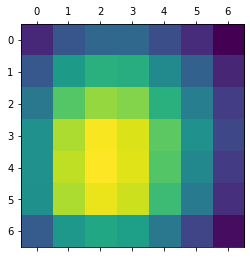

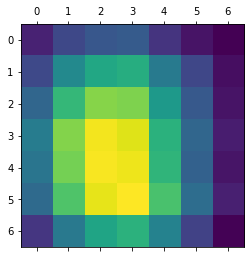

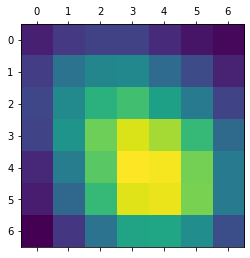

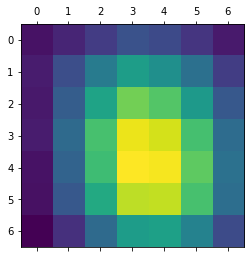

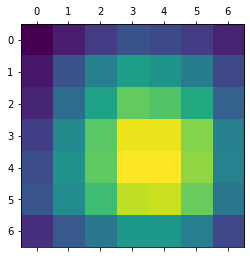

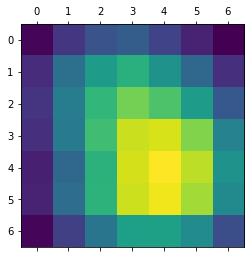

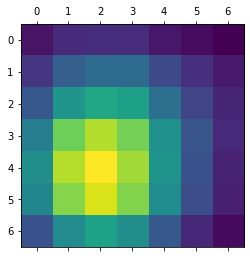

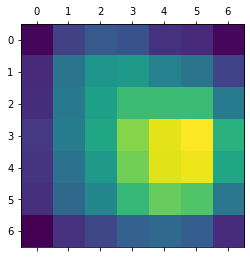

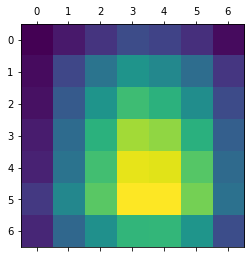

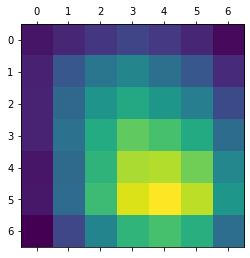

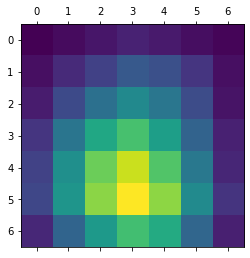

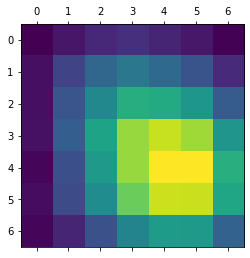

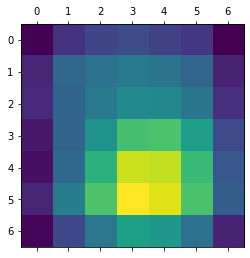

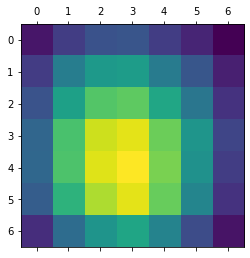

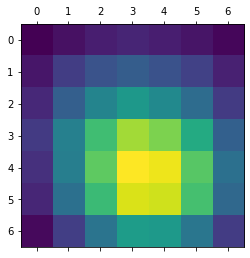

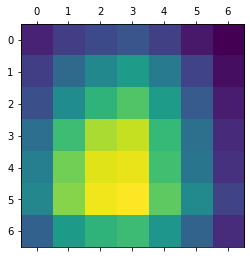

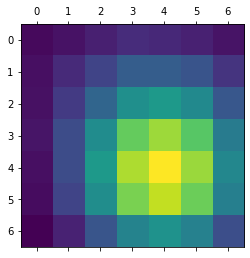

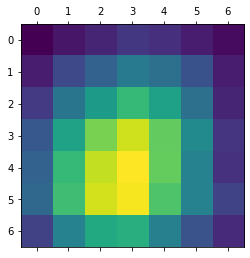

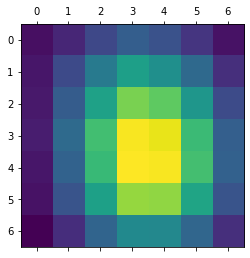

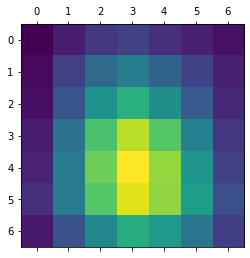

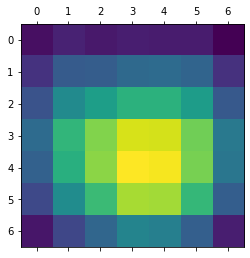

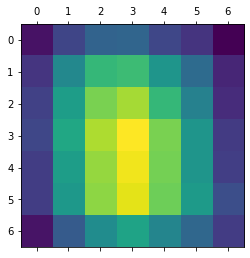

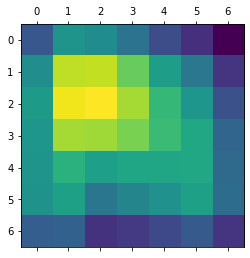

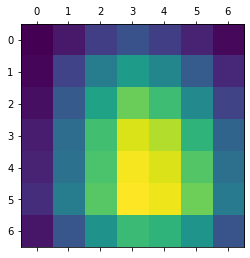

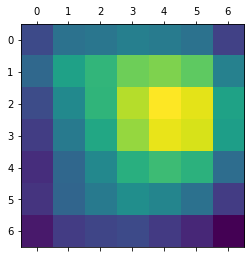

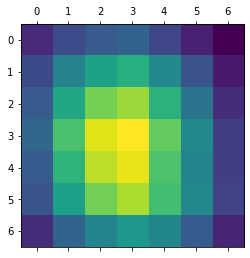

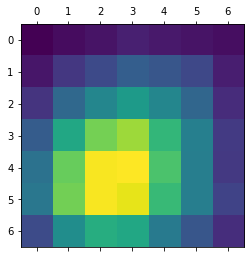

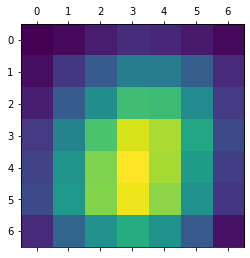

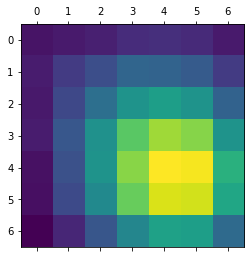

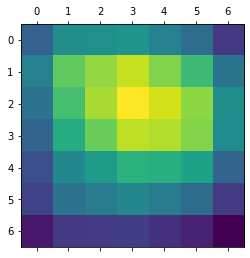

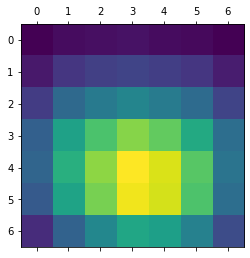

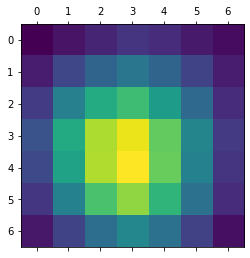

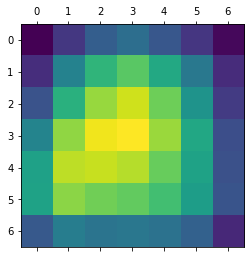

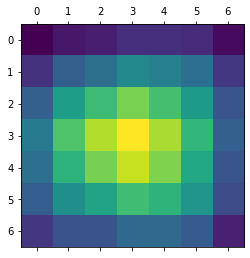

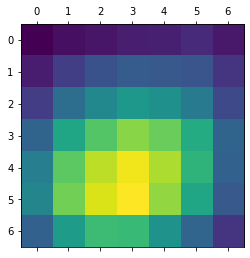

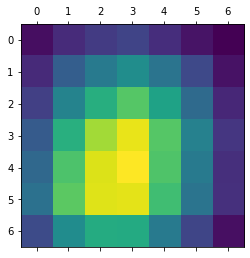

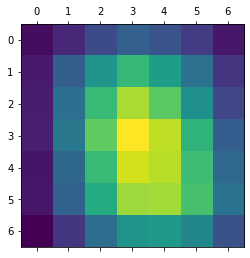

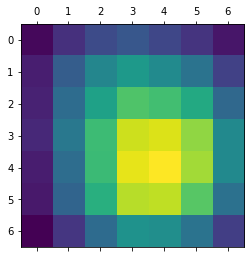

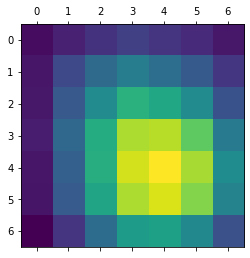

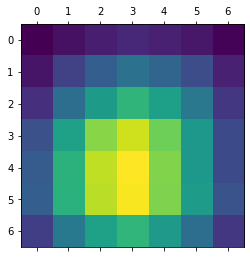

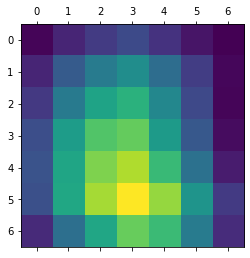

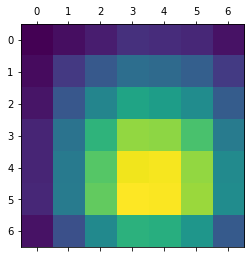

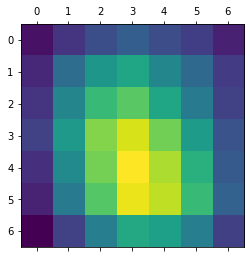

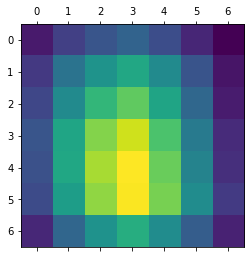

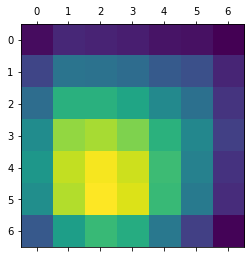

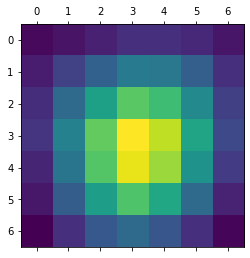

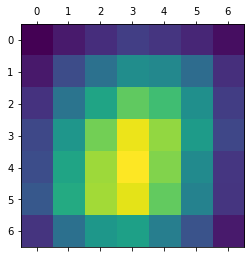

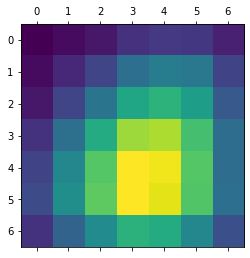

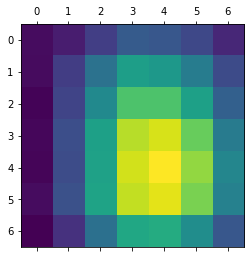

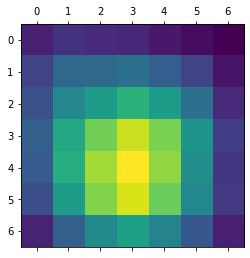

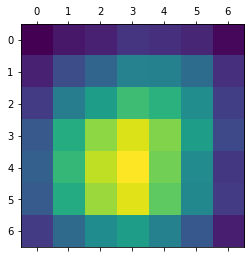

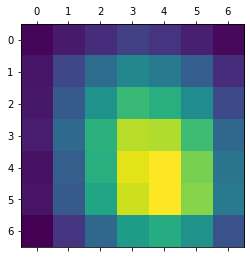

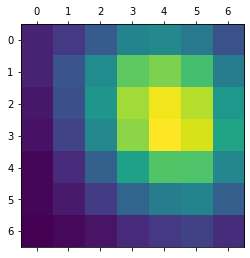

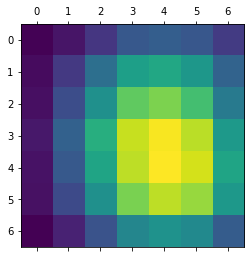

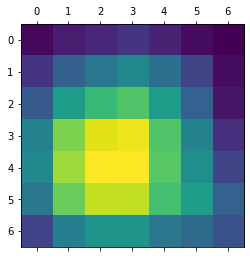

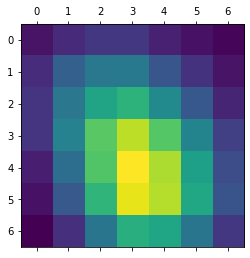

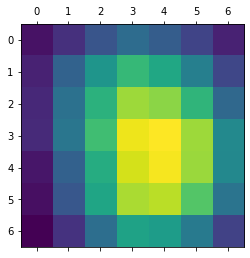

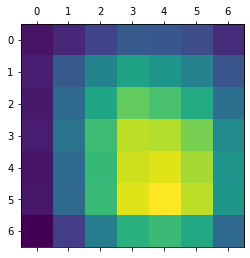

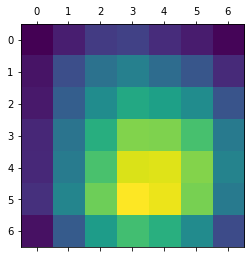

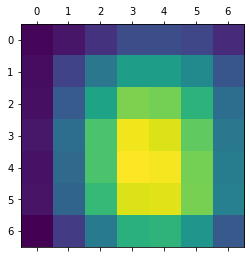

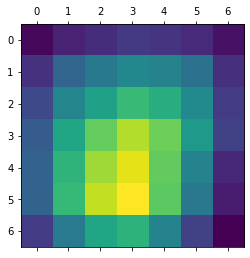

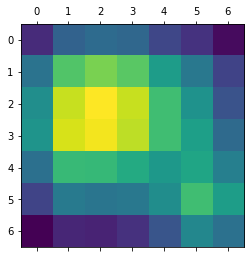

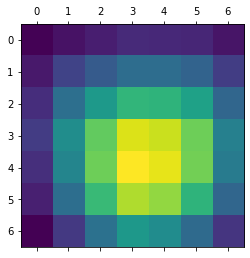

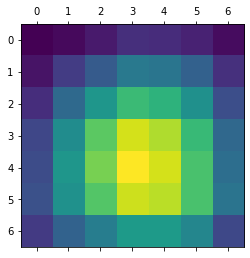

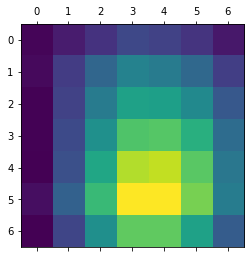

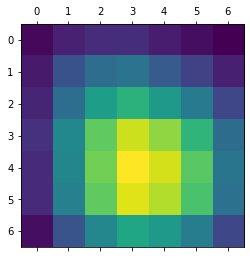

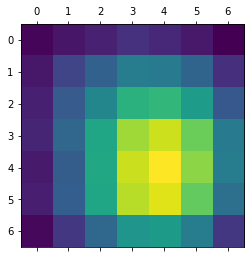

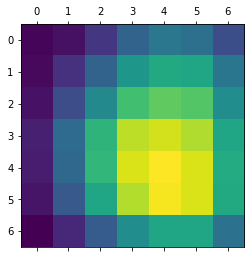

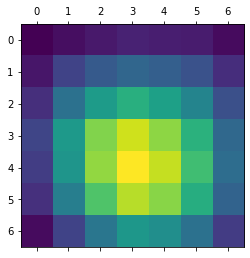

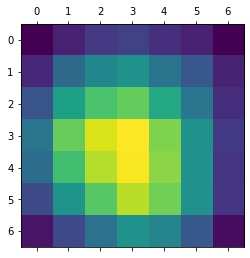

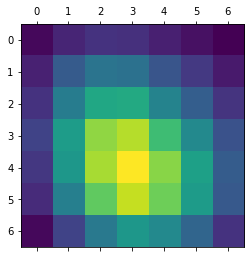

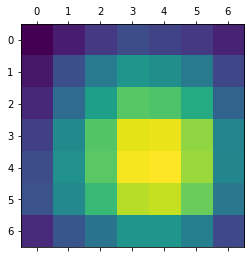

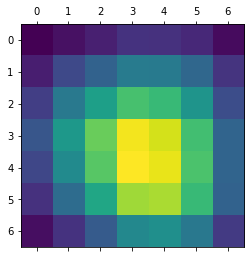

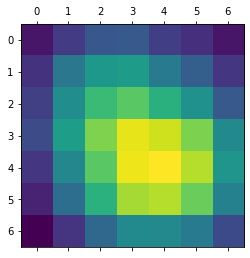

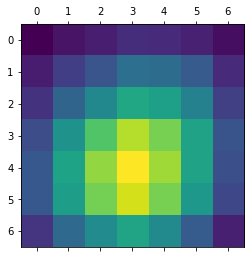

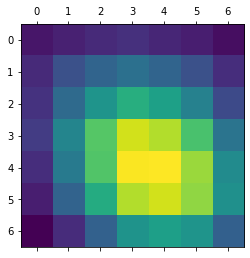

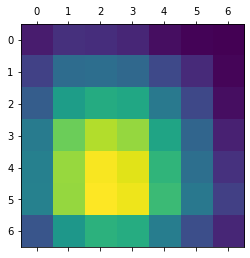

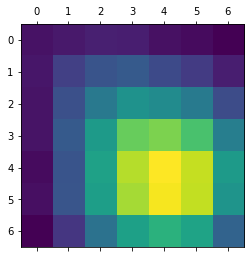

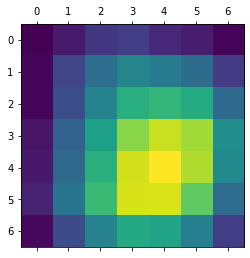

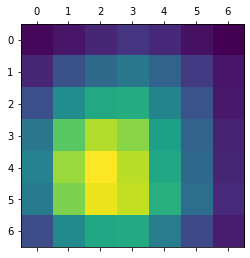

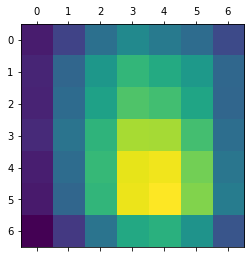

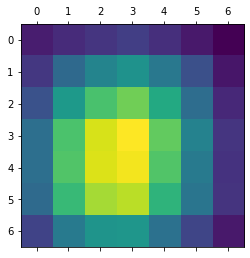

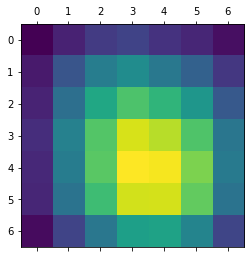

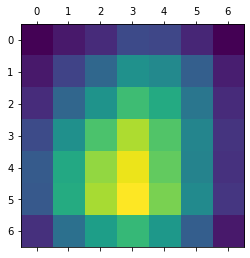

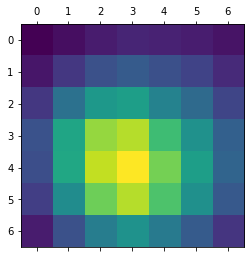

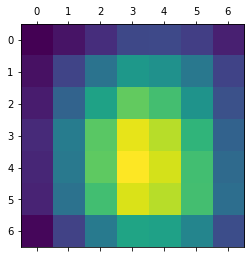

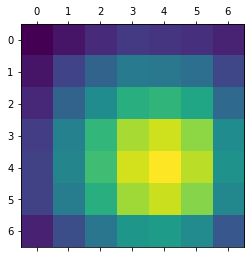

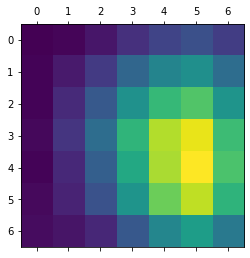

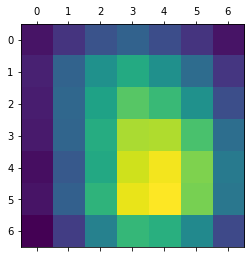

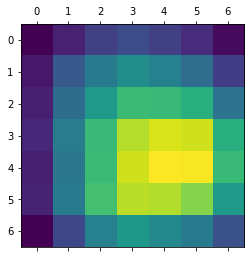

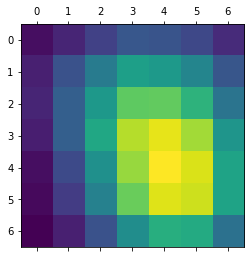

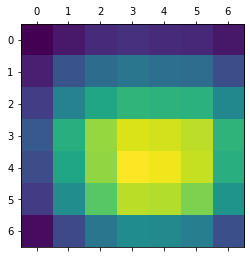

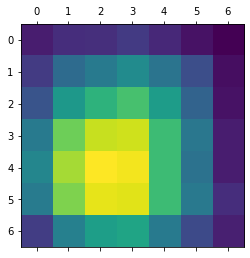

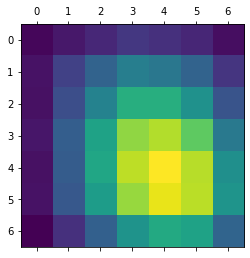

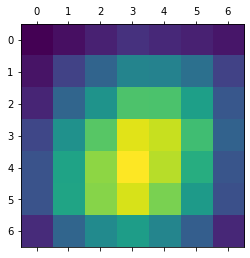

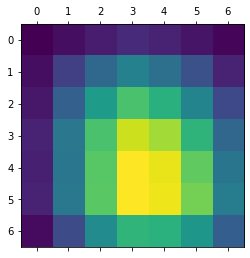

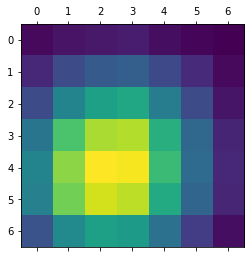

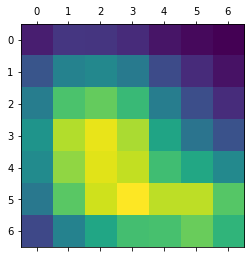

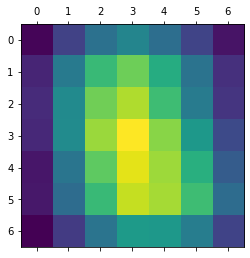

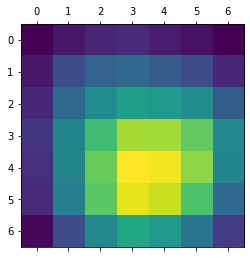

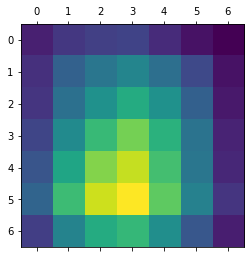

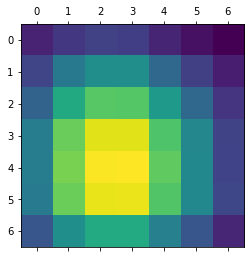

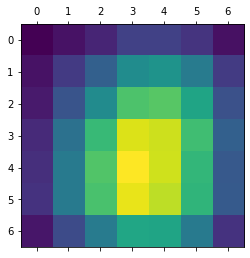

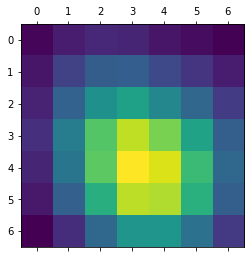

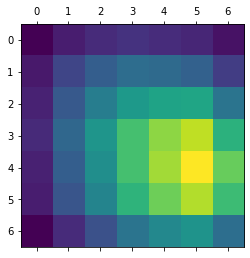

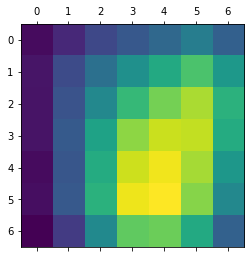

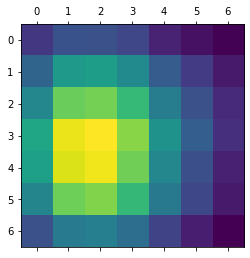

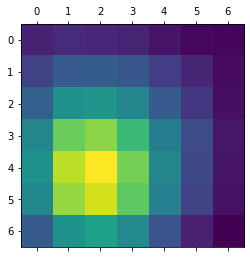

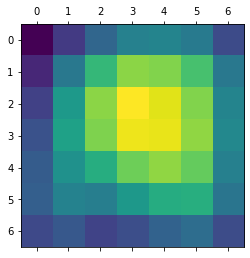

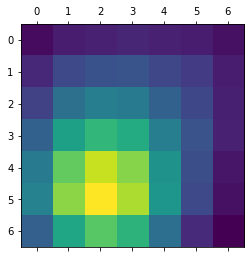

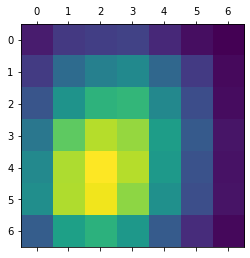

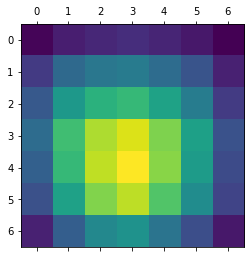

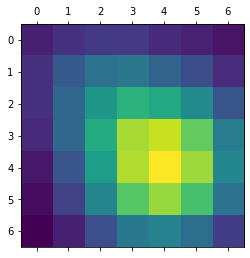

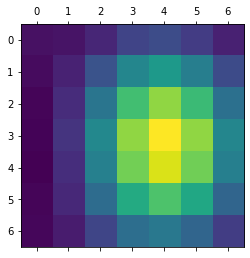

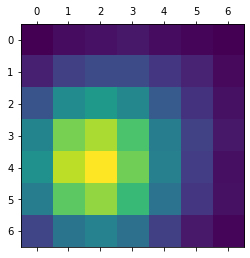

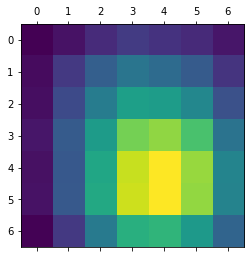

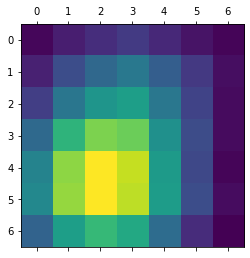

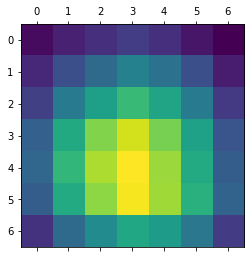

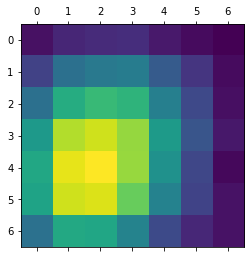

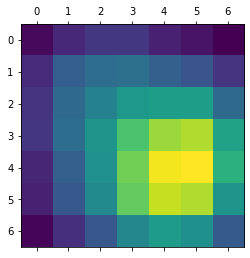

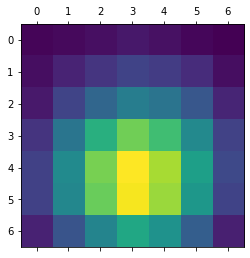

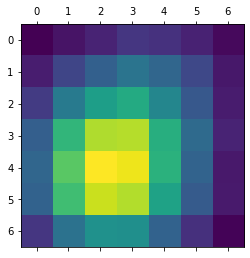

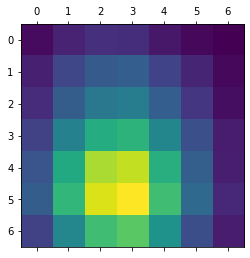

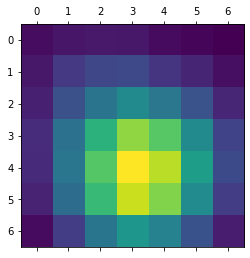

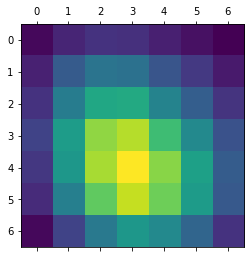

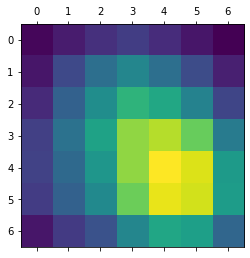

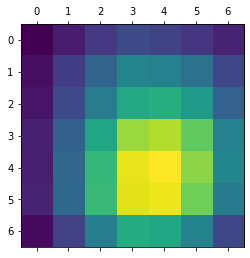

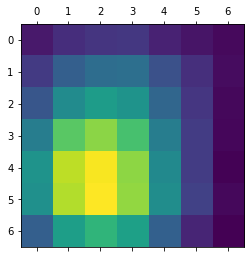

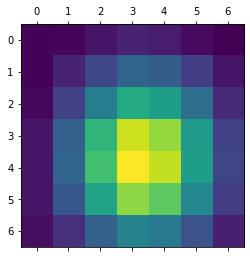

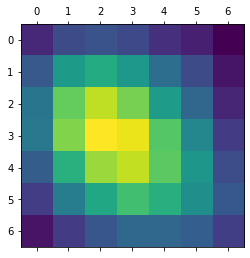

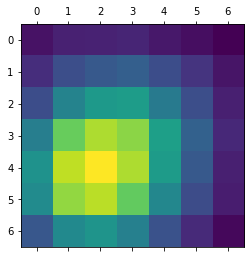

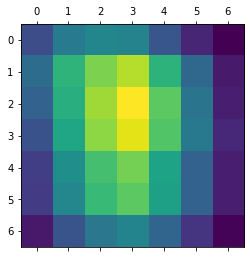

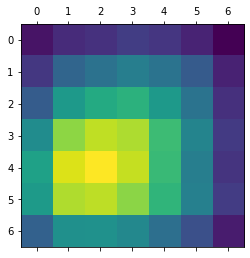

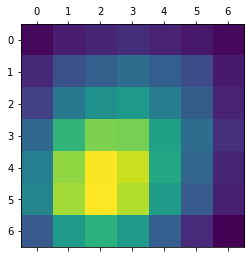

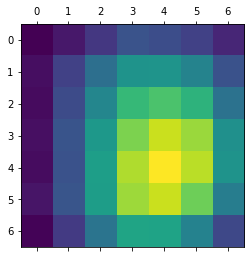

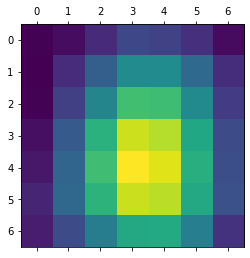

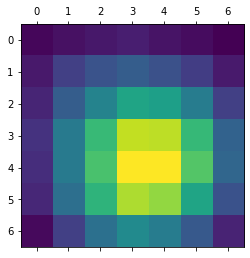

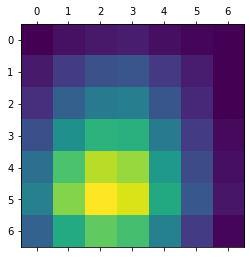

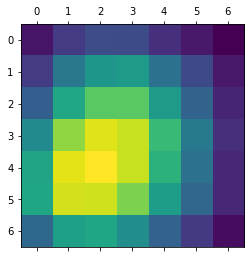

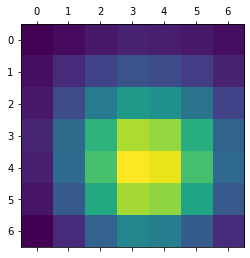

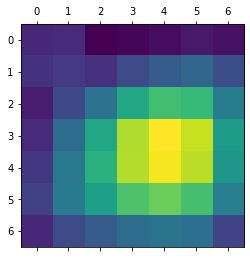

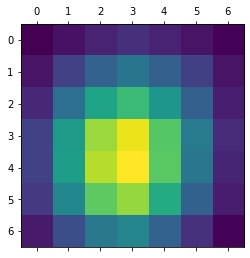

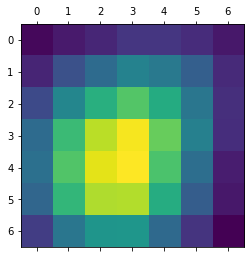

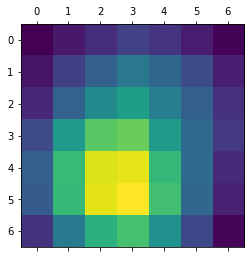

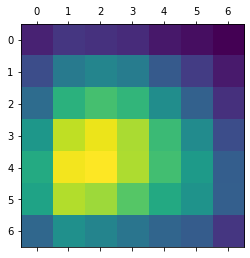

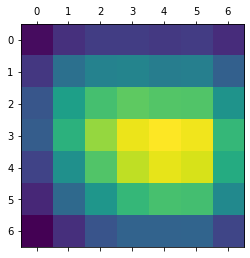

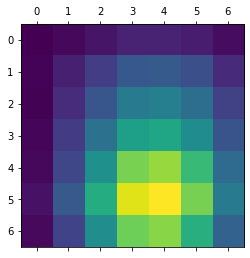

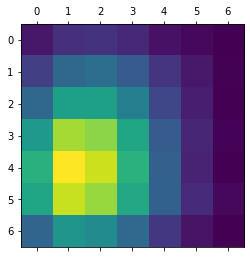

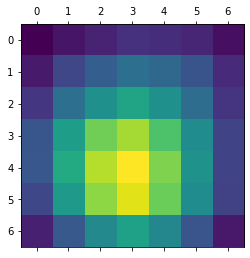

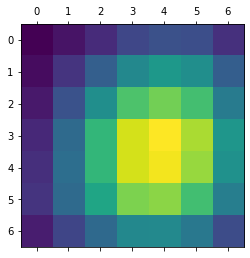

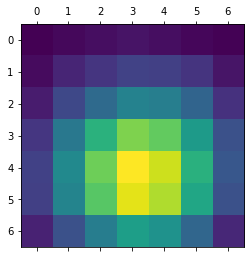

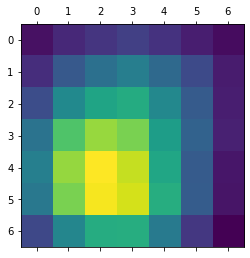

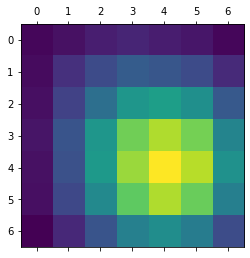

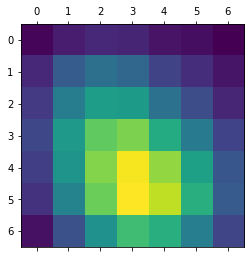

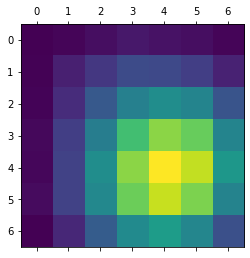

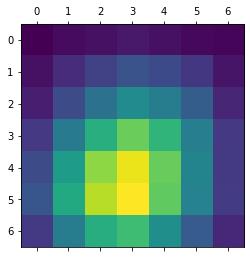

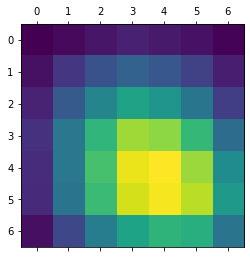

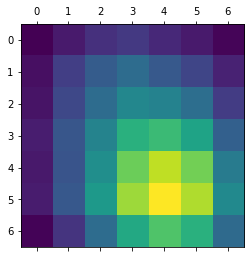

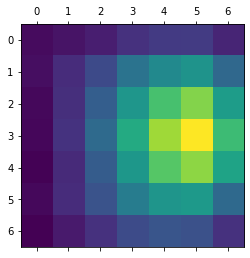

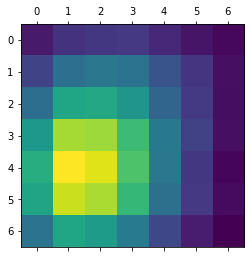

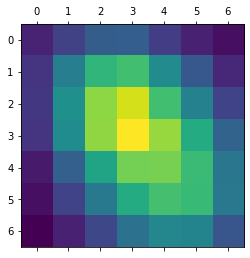

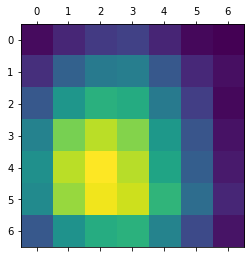

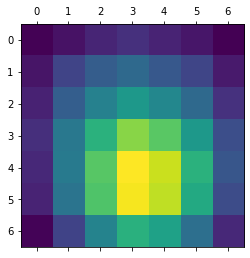

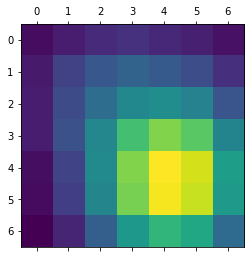

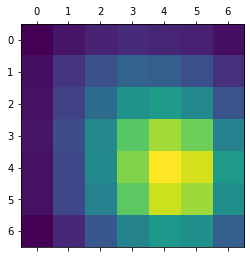

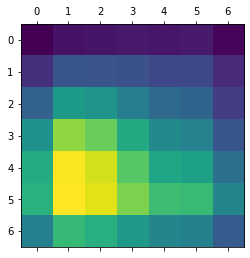

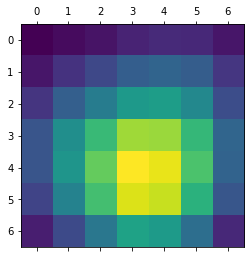

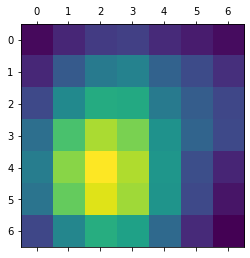

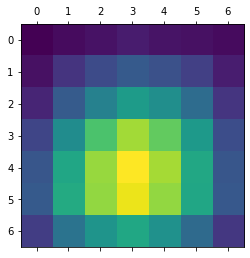

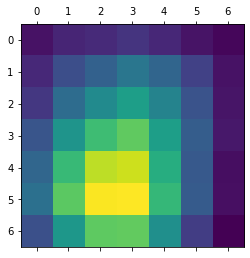

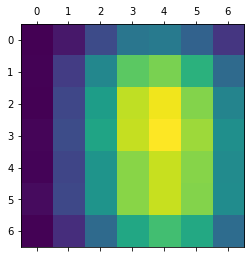

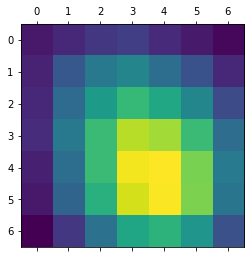

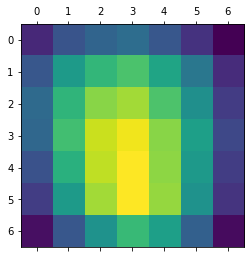

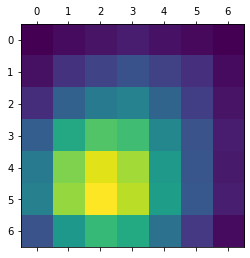

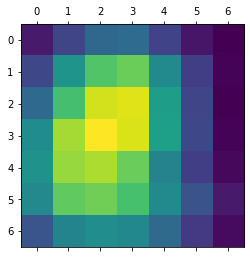

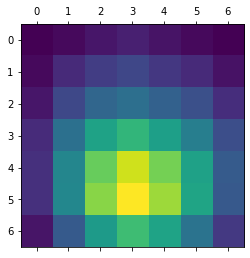

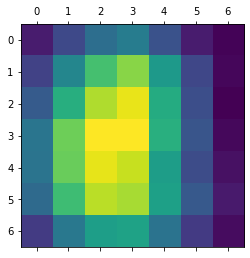

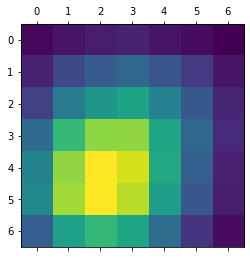

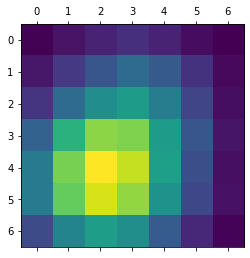

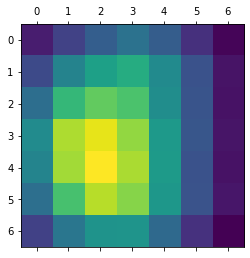

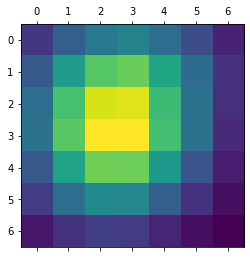

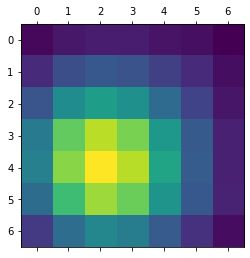

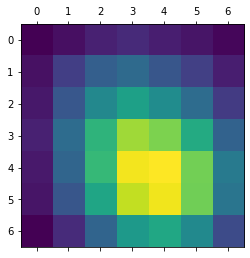

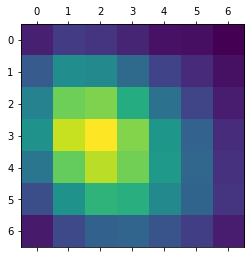

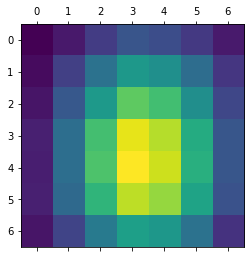

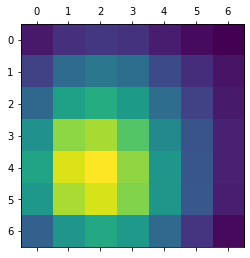

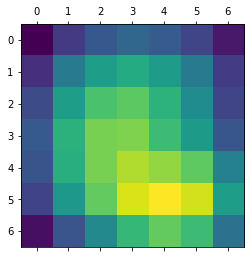

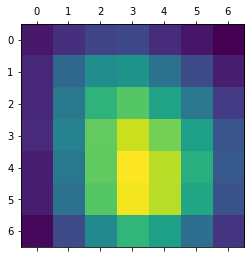

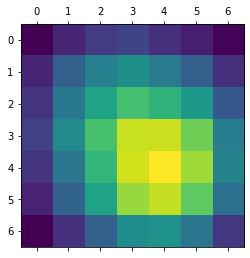

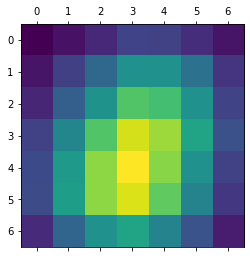

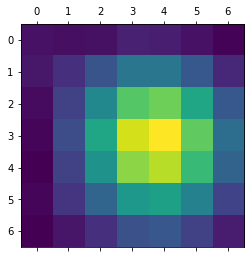

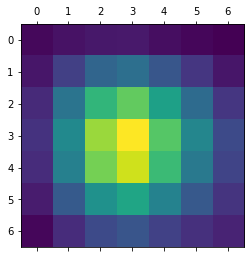

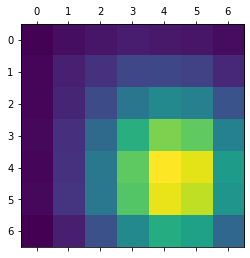

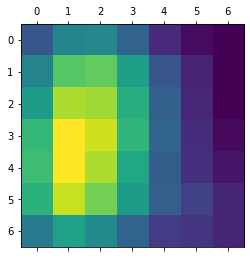

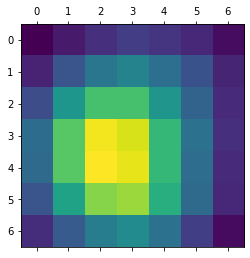

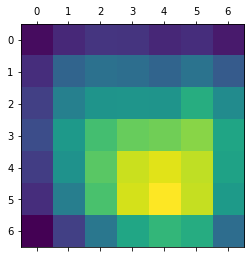

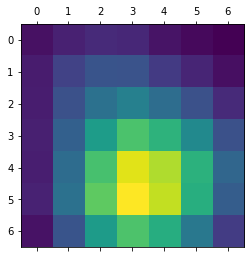

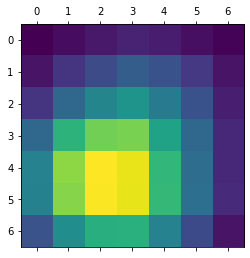

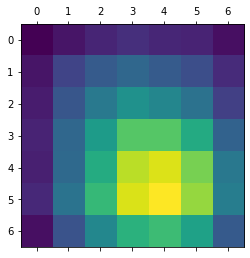

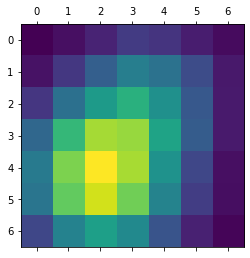

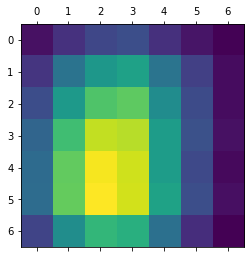

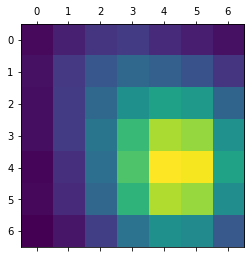

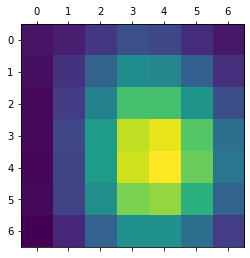

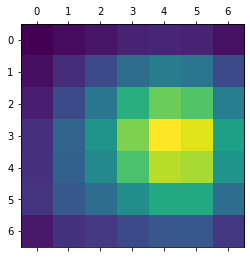

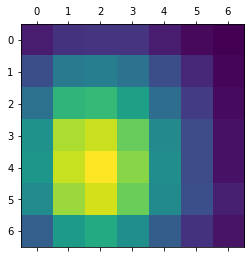

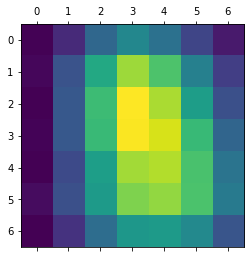

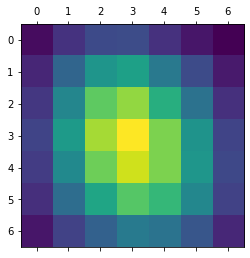

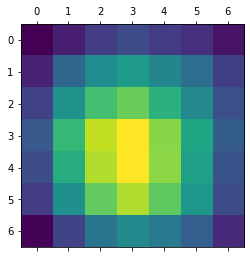

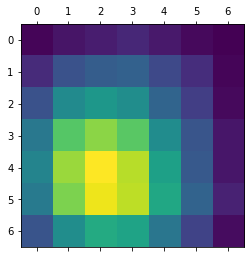

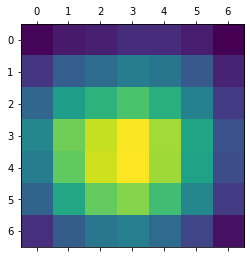

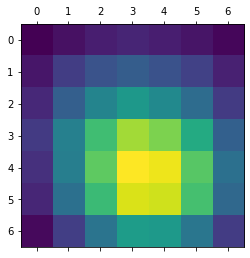

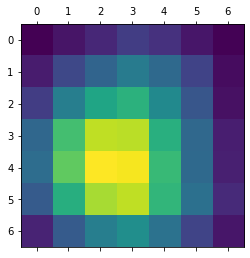

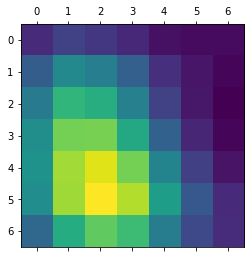

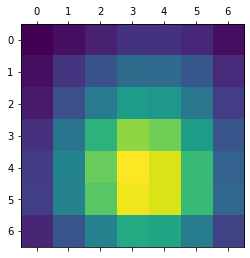

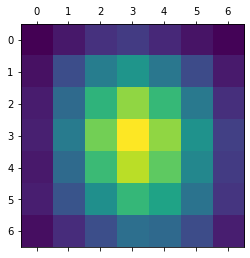

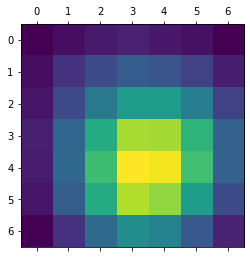

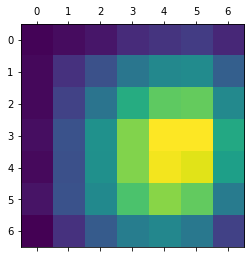

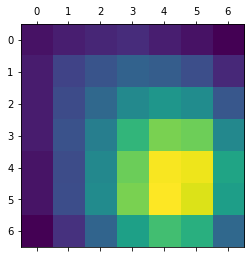

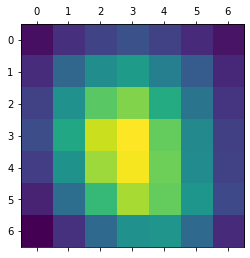

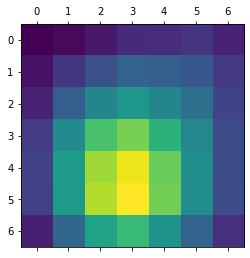

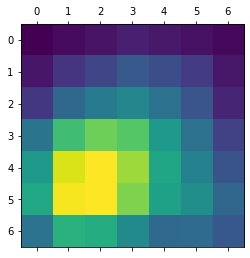

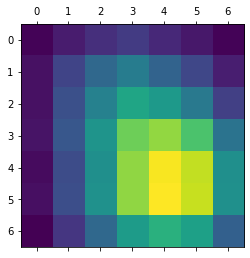

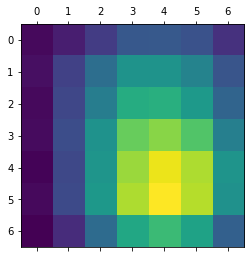

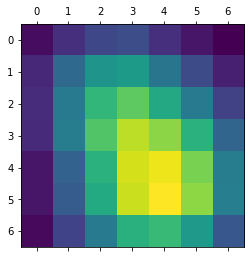

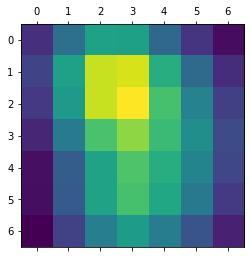

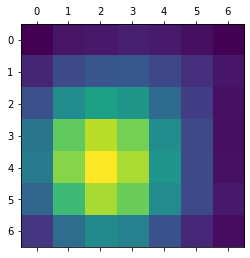

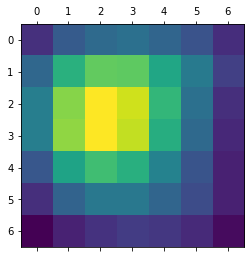

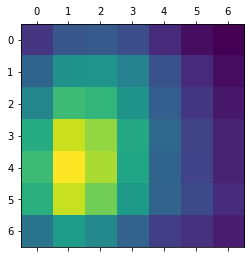

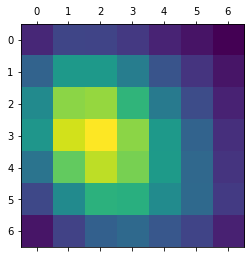

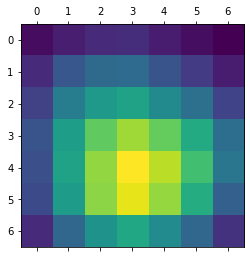

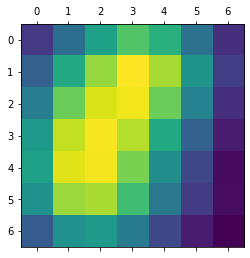

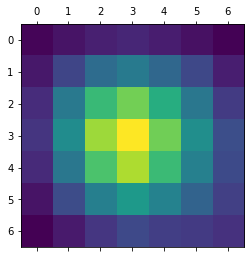

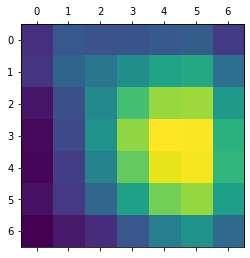

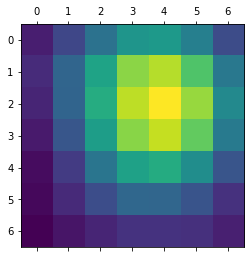

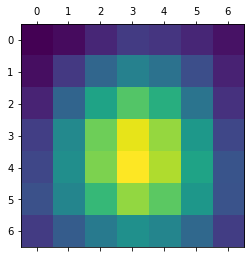

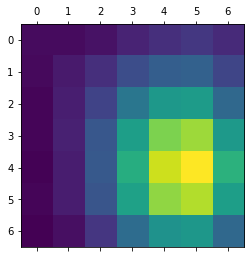

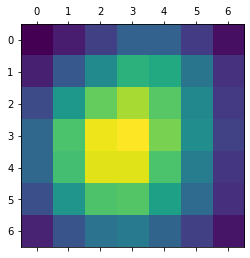

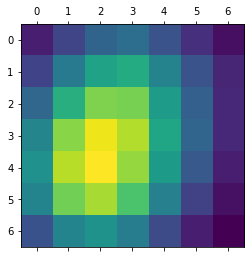

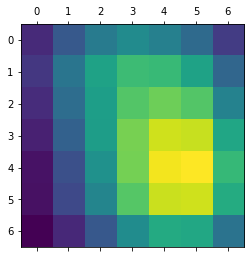

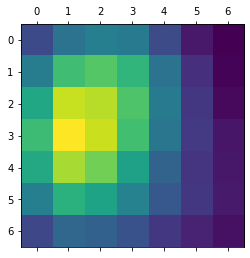

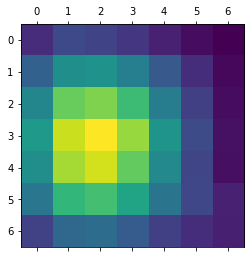

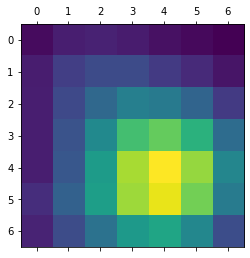

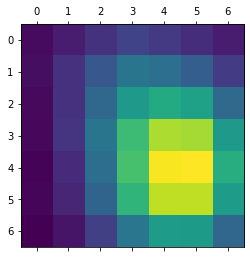

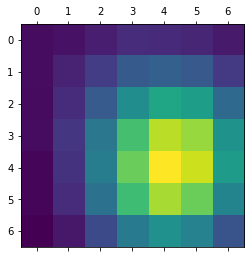

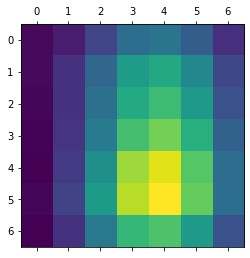

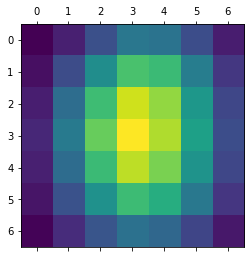

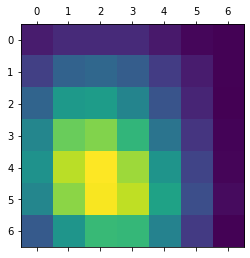

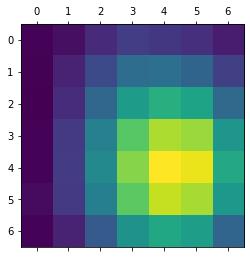

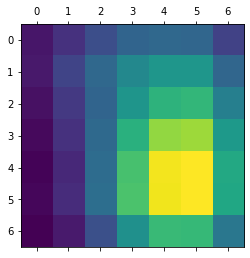

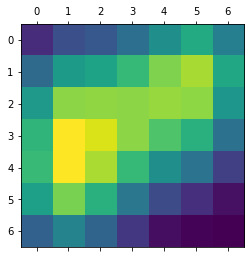

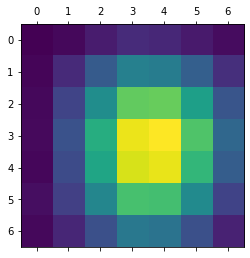

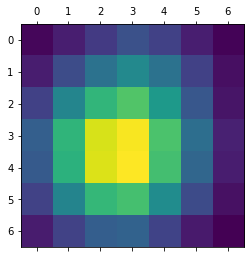

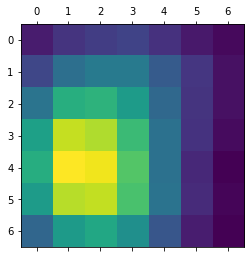

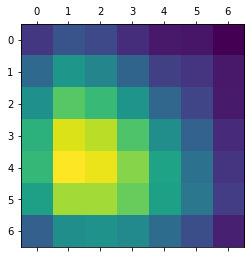

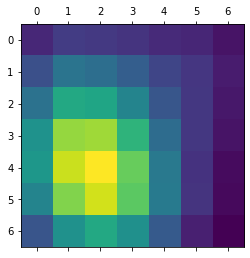

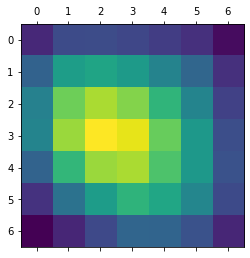

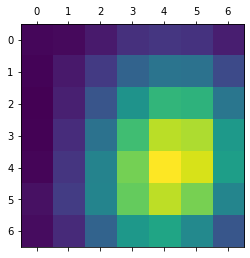

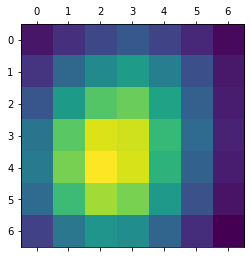

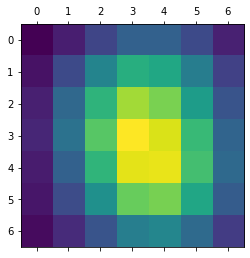

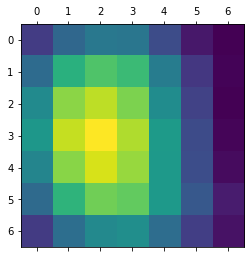

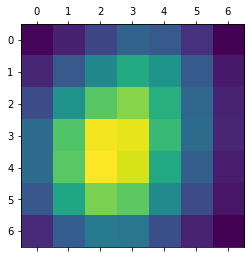

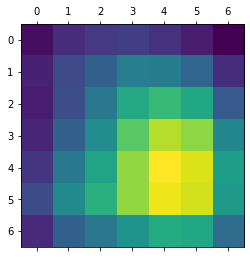

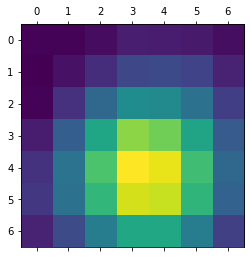

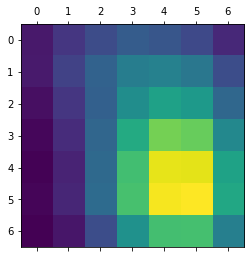

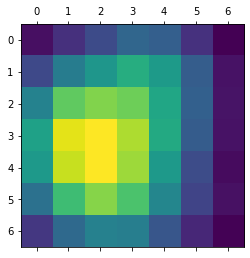

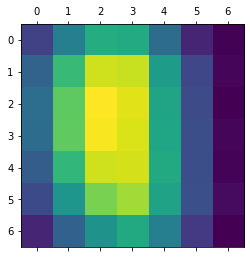

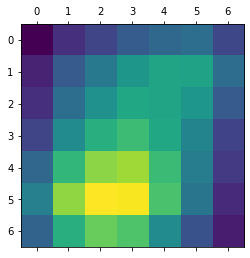

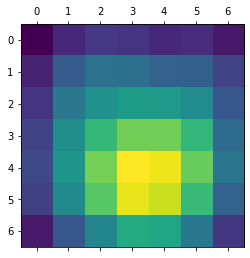

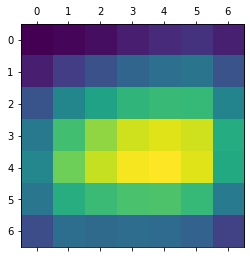

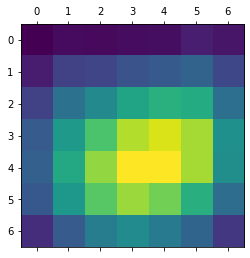

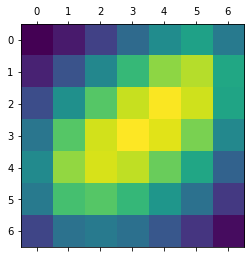

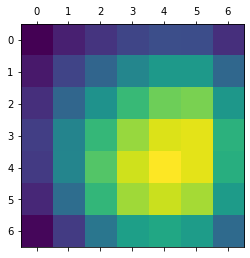

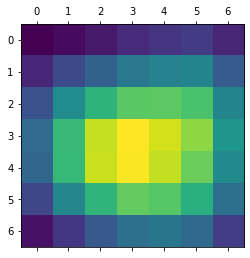

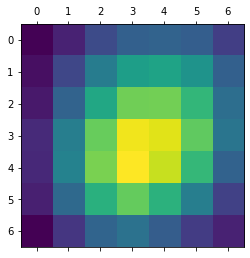

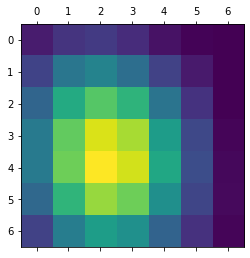

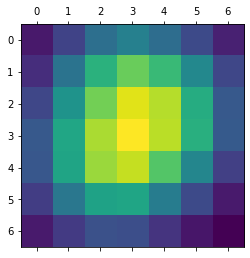

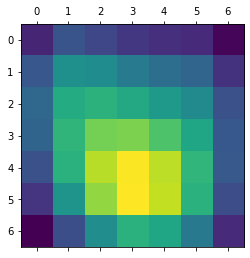

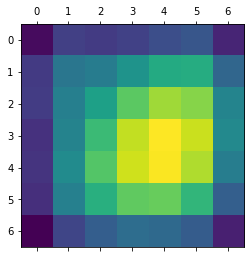

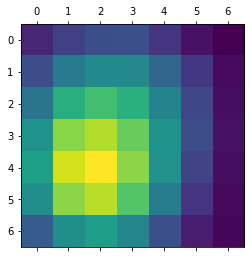

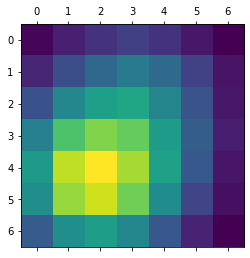

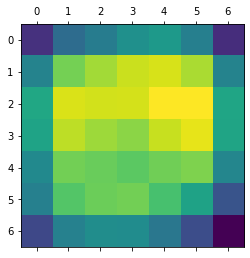

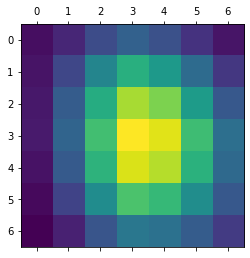

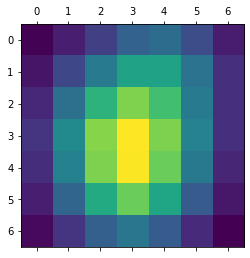

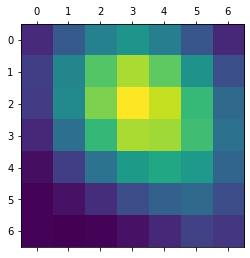

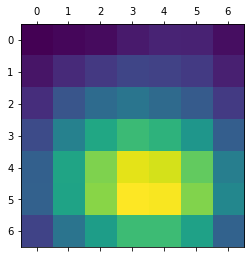

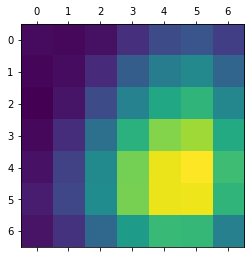

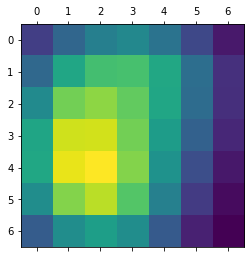

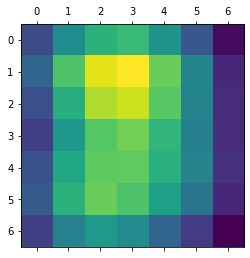

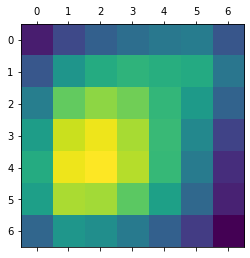

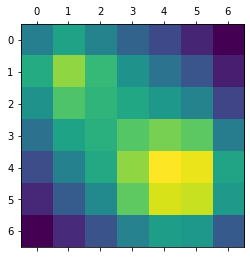

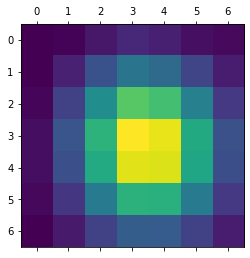

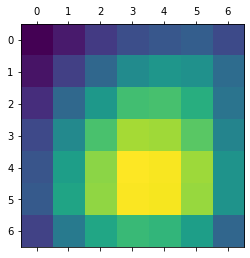

In [ ]:
# import torch
# import torch.nn as nn
# from torchvision.models import resnet152
# from torchvision.datasets import ImageFolder
# from torchvision import transforms
# from torch.utils import data
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2


# # ResNet Class
# class ResNet(nn.Module):
#     def __init__(self):
#         super(ResNet, self).__init__()

#         # define the resnet152
#         self.resnet = resnet152(pretrained=True)

#         # isolate the feature blocks
#         self.features = nn.Sequential(self.resnet.conv1,
#                                       self.resnet.bn1,
#                                       nn.ReLU(),
#                                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
#                                       self.resnet.layer1,
#                                       self.resnet.layer2,
#                                       self.resnet.layer3,
#                                       self.resnet.layer4)

#         # average pooling layer
#         self.avgpool = self.resnet.avgpool

#         # classifier
#         self.classifier = self.resnet.fc

#         # gradient placeholder
#         self.gradient = None

#     # hook for the gradients
#     def activations_hook(self, grad):
#         self.gradient = grad

#     def get_gradient(self):
#         return self.gradient

#     def get_activations(self, x):
#         return self.features(x)

#     def forward(self, x):

#         # extract the features
#         x = self.features(x)

#         # register the hook
#         h = x.register_hook(self.activations_hook)

#         # complete the forward pass
#         x = self.avgpool(x)
#         x = x.view((1, -1))
#         x = self.classifier(x)

#         return x


# # all the data transformation and loading
# #transform = transforms.Compose([transforms.Resize((224, 224)),
# #                                 transforms.ToTensor(),
# #                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# # #dataset = ImageFolder(root=DATA_PATH, transform=transform)
# #dataloader = data.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

# # init the resnet
# resnet = ResNet()

# # set the evaluation mode
# _ = resnet.eval()

 # get the image
#img = next(iter(test_loader))

# # forward pass
# #pred = resnet(img[0])


for step, img in enumerate(test_loader):

  #img = next(iter(test_loader))
  out, acts = gcmodel(img[0])

  pred = resnet34(img[0]) # test_x
  test_fn = all_test_files[step-1]
  print(step)

  print(all_test_files[step-1])
  ##### this prints out the class
  print(out[0].argmax(dim=1)) # prints tensor([0])
  #### count of lesion
  print(out[1].argmax(dim=1))
  ### class based on lesion count
  print(out[2].argmax(dim=1))

  classes1 = out[0].argmax(dim=1).cpu()
  counts1 = out[1].argmax(dim=1).cpu()
  classes2 = out[2].argmax(dim=1).cpu()

  y_preds.append(classes1)
  y_preds_counts.append(counts1)
  y_preds_count2cls.append(classes2)

  acts = acts.detach().cpu()
  loss = nn.CrossEntropyLoss()(out[0],torch.from_numpy(np.array([1])))#.to('cuda:0'))
  loss.backward()
  grads = gcmodel.get_act_grads().detach().cpu()
  pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()
  for i in range(acts.shape[1]):
    acts[:,i,:,:] += pooled_grads[i]

  #print(acts)

  # pred.argmax(dim=1) # prints tensor([2])

  # # get the gradient of the output with respect to the parameters of the model
  # pred[:, 2].backward()

  # # pull the gradients out of the model
  # gradients = resnet.get_gradient()

  # # pool the gradients across the channels
  # pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

  # # get the activations of the last convolutional layer
  # activations = resnet.get_activations(img[0]).detach()

  # # weight the channels by corresponding gradients
  # for i in range(512):
  #     activations[:, i, :, :] *= pooled_gradients[i]



  # average the channels of the activations
  heatmap = torch.mean(acts, dim=1).squeeze()

  # relu on top of the heatmap
  # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
  heatmap = np.maximum(heatmap, 0)

  # normalize the heatmap
  heatmap /= torch.max(heatmap)

  # draw the heatmap
  plt.matshow(heatmap.squeeze())

  # make the heatmap to be a numpy array
  heatmap = heatmap.numpy()

  # interpolate the heatmap
  #img = cv2.imread('/content/gdrive/MyDrive/Project/Classification/JPEGImages/levle0_451.jpg')



 ## base_dir = '/content/gdrive/MyDrive/Colab Notebooks/data/JPEGImages/' #### change to your image folder
  base_dir = '/content/gdrive/MyDrive/Project/Classification/JPEGImages/'
  #test_fn = all_test_files[step]
  test_path = base_dir + test_fn
  #print(test_path)
  #print(type(test_path))
  img = cv2.imread(test_path)
  # change when using a different model
  model_name = 'resnet34'

  #print(type(heatmap))
  #print(type(img))
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  #cv2.imwrite('./map.jpg', superimposed_img)
  cv2.imwrite('/content/gdrive/MyDrive/Project/Heatmaps Resnet 34/' + all_test_files[step-1] + '.jpg', superimposed_img)

  #np.save('/content/gdrive/MyDrive/Project/Classes and Counts Resnet 152/Classes/' + all_test_files[step-1], classes1)
  #np.save('/content/gdrive/MyDrive/Project/Classes and Counts Resnet 152/Counts/' + all_test_files[step-1], counts1)
  #np.save('/content/gdrive/MyDrive/Project/Classes and Counts Resnet 152/Classes from Counts/' + all_test_files[step-1], classes2)

preds = np.array([y_preds, y_preds_counts, y_preds_count2cls])
print(preds)
np.save('/content/gdrive/MyDrive/Project/image classes and counts/counts-class-resnet34', preds)
  #pass